<Figure size 1000x600 with 0 Axes>

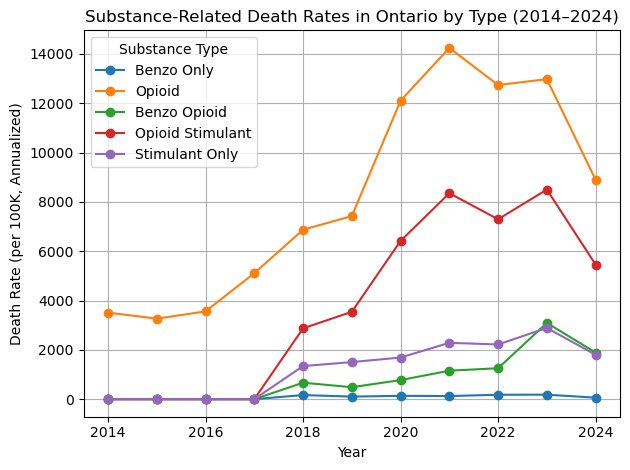

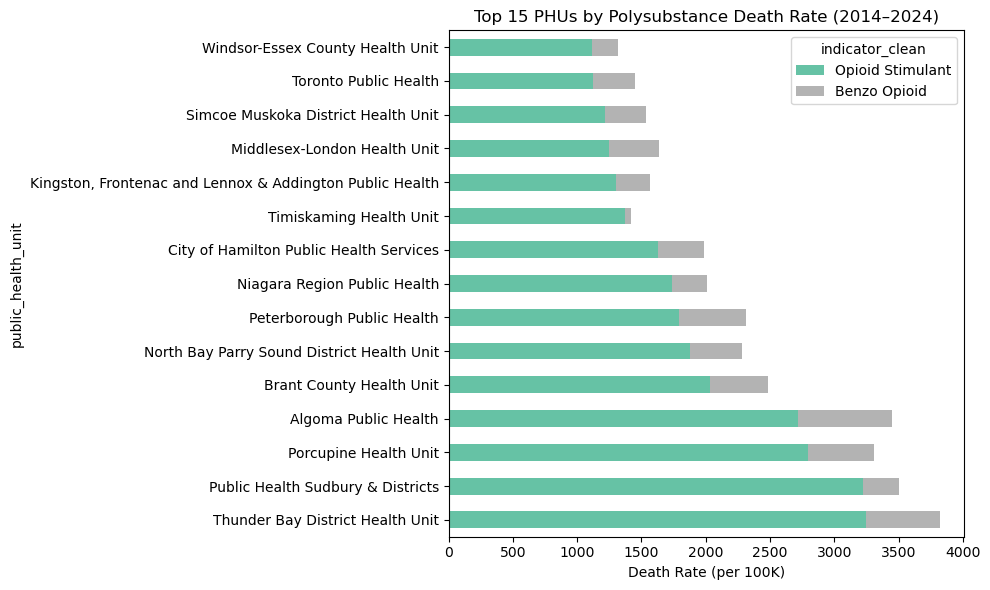

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("C://Users//shoaib//Desktop//Mental_health_ed_project//Cleaned_dataset//pho_ed_visits_phu_month_2014-2024.csv.csv")  # replace with your filename

# Normalize indicator field (lowercase + strip spaces)
df['indicator_clean'] = df['indicator'].str.lower().str.strip()

# Define substance death categories of interest
substance_indicators = {
    'opioid': 'deaths due to opioid toxicity',
    'opioid_stimulant': 'deaths due to opioid toxicity (with stimulant involvement)',
    'stimulant_only': 'deaths due to stimulant toxicity (without opioid involvement)',
    'benzo_opioid': 'deaths due to opioid toxicity (with benzodiazepine involvement)',
    'benzo_only': 'deaths due to benzodiazepine toxicity (without opioid involvement)'
}

# Filter to PHU-level only (exclude Ontario-wide aggregates)
df = df[df['public_health_unit'].str.lower() != 'ontario']

# Parse year from start date
df['year'] = pd.to_datetime(df['start_date_of_time_period'], errors='coerce').dt.year

# -----------------------------
# Trend Plot (Rate per 100K)
# -----------------------------
summary_rate = (
    df[df['indicator_clean'].isin(substance_indicators.values())]
    .groupby(['indicator_clean', 'year'])['cases_per_100_000_population_annualized']
    .sum()
    .reset_index()
)

# Pivot for plotting
pivot_rate = summary_rate.pivot(index='year', columns='indicator_clean', values='cases_per_100_000_population_annualized').fillna(0)

# Rename columns for clarity
pivot_rate = pivot_rate.rename(columns={v: k.replace("_", " ").title() for k, v in substance_indicators.items()})

# Plot trends over time
plt.figure(figsize=(10, 6))
pivot_rate.plot(marker='o')
plt.title("Substance-Related Death Rates in Ontario by Type (2014–2024)")
plt.ylabel("Death Rate (per 100K, Annualized)")
plt.xlabel("Year")
plt.grid(True)
plt.legend(title="Substance Type")
plt.tight_layout()
plt.show()

# -----------------------------
# PHU Breakdown (Top 15 PHUs by Polysubstance Deaths)
# -----------------------------
top_phus = (
    df[df['indicator_clean'].isin(substance_indicators.values())]
    .groupby(['public_health_unit', 'indicator_clean'])['cases_per_100_000_population_annualized']
    .sum()
    .reset_index()
)

# Pivot table
top_phus_pivot = top_phus.pivot(index='public_health_unit', columns='indicator_clean', values='cases_per_100_000_population_annualized').fillna(0)

# Rename for readability
top_phus_pivot = top_phus_pivot.rename(columns={v: k.replace("_", " ").title() for k, v in substance_indicators.items()})

# Filter top PHUs by Opioid Stimulant rates
top_subs = ['Opioid Stimulant', 'Benzo Opioid']
top_phus_sub = top_phus_pivot[top_subs].sort_values(by='Opioid Stimulant', ascending=False).head(15)

# Plot
top_phus_sub.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title("Top 15 PHUs by Polysubstance Death Rate (2014–2024)")
plt.xlabel("Death Rate (per 100K)")
plt.tight_layout()
plt.show()


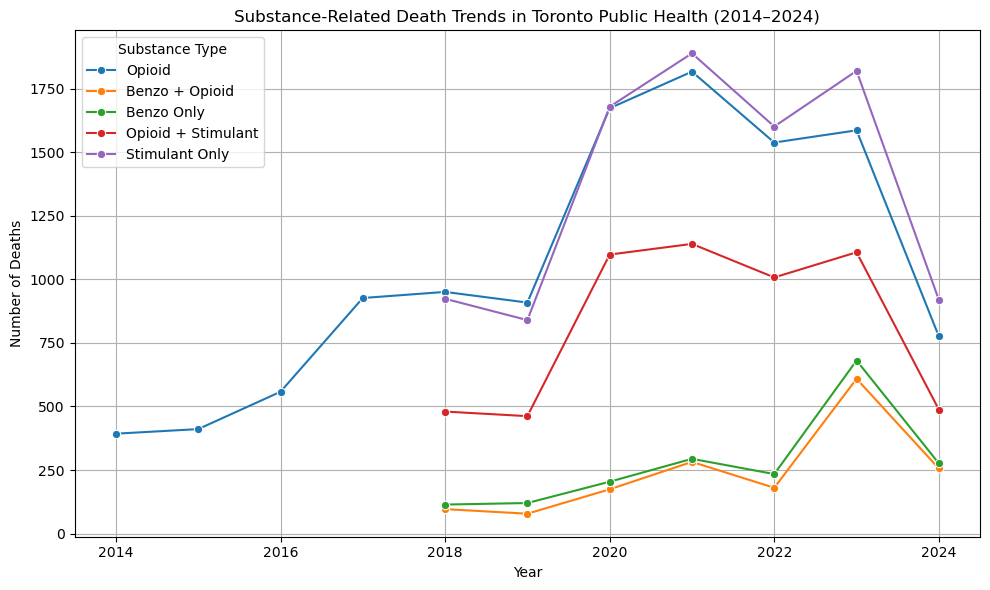

In [27]:
selected_phu = "Toronto Public Health"

# Filter data
df_phu = df[df["public_health_unit"].str.lower() == selected_phu.lower()].copy()

# Standardize indicator labels for grouping (adjust if needed)
indicator_mapping = {
    "Deaths due to opioid toxicity": "Opioid",
    "Deaths due to opioid toxicity (with stimulant involvement)": "Opioid + Stimulant",
    "Deaths due to opioid toxicity (with benzodiazepine involvement)": "Benzo + Opioid",
    "Deaths due to stimulant toxicity": "Stimulant Only",
    "Deaths due to stimulant toxicity (without opioid involvement)": "Stimulant Only",
    "Deaths due to benzodiazepine toxicity": "Benzo Only",
    "Deaths due to benzodiazepine toxicity (without opioid involvement)": "Benzo Only"
}
df_phu["indicator_clean"] = df_phu["indicator"].map(indicator_mapping)

# Convert time period to year
df_phu["year"] = pd.to_datetime(df_phu["start_date_of_time_period"]).dt.year

# Group and aggregate
df_summary = df_phu.groupby(["year", "indicator_clean"], as_index=False)["number_of_cases"].sum()

# -----------------------------
# 📊 Plotting
# -----------------------------
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_summary, x="year", y="number_of_cases", hue="indicator_clean", marker="o")
plt.title(f"Substance-Related Death Trends in {selected_phu} (2014–2024)")
plt.ylabel("Number of Deaths")
plt.xlabel("Year")
plt.legend(title="Substance Type")
plt.grid(True)
plt.tight_layout()
plt.show()

Error checking

In [5]:
import pandas as pd

# Load your dataset
file_path = "C://Users//shoaib//Desktop//Mental_health_ed_project//Cleaned_dataset//pho_ed_visits_phu_month_2014-2024.csv.csv" # Replace with your actual file path
df = pd.read_csv(file_path)

# Preview structure
print("Columns:", df.columns.tolist())
print("Sample data:")
print(df.head())

#  Check for missing values
print("\n Missing values per column:")
print(df.isnull().sum())

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

#  Check unique years
if 'year' in df.columns:
    print("\n Unique years:", sorted(df['year'].unique()))
    print(" Year range: {} to {}".format(df['year'].min(), df['year'].max()))

# Unique substance types
if 'substance_type' in df.columns:
    print("\n Unique substance types:")
    print(df['substance_type'].dropna().unique())

# Unique PHUs
if 'public_health_unit' in df.columns:
    phu_counts = df['public_health_unit'].nunique()
    print(f"\nUnique PHUs: {phu_counts}")
    print("✅ Sample PHUs:")
    print(df['public_health_unit'].dropna().unique()[:10])

#  Check for duplicates
duplicates = df.duplicated()
print(f"\n Duplicate rows: {duplicates.sum()}")

# 🧾 Check negative or zero death counts
if 'number_of_deaths' in df.columns:
    invalid_deaths = df[df['number_of_deaths'] <= 0]
    print(f"\n Entries with zero or negative deaths: {len(invalid_deaths)}")
    print(invalid_deaths.head())

# Aggregate totals (optional sanity check)
if {'year', 'number_of_deaths'}.issubset(df.columns):
    summary = df.groupby('year')['number_of_deaths'].sum()
    print("\nTotal deaths per year:")
    print(summary)

# check spelling issues in substance type
print("\nNormalized substance labels (sample):")
print(df['indicator'].str.lower().str.strip().value_counts().head())

# pivot to check structure
if {'year', 'indicator', 'number_of_deaths'}.issubset(df.columns):
    pivot_check = df.pivot_table(index='year', columns='substance_type', values='number_of_deaths', aggfunc='sum')
    print("\nPivot table (deaths by substance per year):")
    print(pivot_check.head())




Columns: ['public_health_unit', 'indicator', 'time_interval', 'time_period', 'start_date_of_time_period', 'end_date_of_time_period', 'number_of_cases', 'population', 'cases_per_100_000_population_annualized']
Sample data:
  public_health_unit                                   indicator  \
0            Ontario  ED visits due to opioid-related poisonings   
1            Ontario  ED visits due to opioid-related poisonings   
2            Ontario  ED visits due to opioid-related poisonings   
3            Ontario  ED visits due to opioid-related poisonings   
4            Ontario  ED visits due to opioid-related poisonings   

  time_interval time_period start_date_of_time_period end_date_of_time_period  \
0       Monthly   2014 - 01                  1/1/2014               1/31/2014   
1       Monthly   2014 - 02                  2/1/2014               2/28/2014   
2       Monthly   2014 - 03                  3/1/2014               3/31/2014   
3       Monthly   2014 - 04                  

In [23]:
df.dropna(how='all')


,public_health_unit,indicator,time_interval,time_period,start_date_of_time_period,end_date_of_time_period,number_of_cases,population,cases_per_100_000_population_annualized
0,Ontario,ED visits due to opioid-related poisonings,Monthly,2014 - 01,1/1/2014,1/31/2014,247.0,13564168.0,21.851690
1,Ontario,ED visits due to opioid-related poisonings,Monthly,2014 - 02,2/1/2014,2/28/2014,249.0,13573065.0,22.014188
2,Ontario,ED visits due to opioid-related poisonings,Monthly,2014 - 03,3/1/2014,3/31/2014,270.0,13581963.0,23.855167
3,Ontario,ED visits due to opioid-related poisonings,Monthly,2014 - 04,4/1/2014,4/30/2014,234.0,13590861.0,20.660943
4,Ontario,ED visits due to opioid-related poisonings,Monthly,2014 - 05,5/1/2014,5/31/2014,272.0,13599758.0,24.000427
...,...,...,...,...,...,...,...,...,...
42626,York Region Public Health,Deaths due to benzodiazepine toxicity (without...,Yearly,2020,1/1/2020,12/31/2020,2.0,1192038.0,0.167780
42627,York Region Public Health,Deaths due to benzodiazepine toxicity (without...,Yearly,2021,1/1/2021,12/31/2021,0.0,1205623.0,0.000000
42628,York Region Public Health,Deaths due to benzodiazepine toxicity (without...,Yearly,2022,1/1/2022,12/31/2022,2.0,1219986.0,0.163936
42629,York Region Public Health,Deaths due to benzodiazepine toxicity (without...,Yearly,2023,1/1/2023,12/31/2023,3.0,1239902.0,0.241955


analysis 2


<Axes: title={'center': 'Population by Year (Ontario)'}, xlabel='year'>

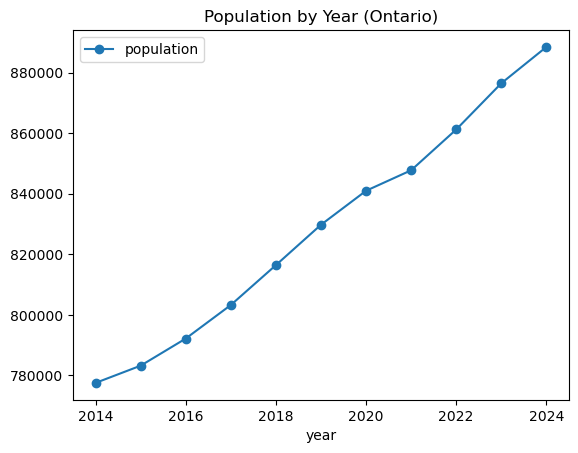

In [9]:
df_annual[['year', 'population']].plot(x='year', y='population', marker='o', title='Population by Year (Ontario)')
